In [81]:
from __future__ import print_function
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 12
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("california_housing_train.csv",sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [82]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ['latitude',
         'longitude',
         'housing_median_age',
         'total_rooms',
         'total_bedrooms',
         'population',
         'households',
         'median_income']]
    processed_feature = selected_features.copy()
    processed_feature['rooms_per_person'] = (california_housing_dataframe['total_rooms']/california_housing_dataframe['population'])
    return processed_feature

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets['median_house_value'] = (california_housing_dataframe['median_house_value']/1000)
    return output_targets

In [83]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2644.3,540.8,1430.2,502.3,3.9,2.0
std,2.1,2.0,12.6,2185.1,421.4,1103.8,383.7,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1462.0,296.0,793.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.5,435.0,1169.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3155.2,652.2,1724.0,607.2,4.8,2.3
max,42.0,-114.5,52.0,37937.0,5471.0,16122.0,5189.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.6,2642.3,536.0,1428.1,498.7,3.9,2.0
std,2.2,2.0,12.6,2167.7,421.8,1247.3,386.6,2.0,1.0
min,32.5,-124.3,1.0,12.0,3.0,11.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1463.0,298.0,777.0,281.0,2.6,1.5
50%,34.3,-118.5,28.0,2131.0,430.0,1161.0,406.0,3.6,2.0
75%,37.7,-118.0,37.0,3137.0,642.0,1715.0,599.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,34.2


Training targets summary:


,median_house_value
count,12000.0
mean,206.7
std,115.0
min,15.0
25%,120.6
50%,180.6
75%,262.9
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.7
std,118.4
min,15.0
25%,118.1
50%,179.5
75%,269.7
max,500.0


In [84]:

def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [85]:
def my_input_fn(features,targets,batch_size=1,shuffle=True,num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
    
    features,labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [89]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 13
    steps_per_period = steps / periods
    
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns = construct_feature_columns(training_examples),
        hidden_units = hidden_units,
        optimizer = my_optimizer
    )    
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["median_house_value"],
                                            batch_size = batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets["median_house_value"],
                                                    num_epochs=1,
                                                    shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                      validation_targets["median_house_value"],  
                                                      num_epochs=1,
                                                      shuffle=False)
    print("Training Model ...")
    print("RMSE(On the training data):")
    training_rmse =[]
    validation_rmse = []
    for period in range(0,periods):
        dnn_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        training_predictions = dnn_regressor.predict(input_fn = predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = dnn_regressor.predict(input_fn = predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions,validation_targets))
        
        print("Period %02d : %0.2f"%(period,training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished")
    
    plt.xlabel("Period")
    plt.ylabel("RMSE")
    plt.title("Root Mean Squared Error vs Periods")
    plt.tight_layout()
    plt.plot(training_rmse,label="Training RMSE")
    plt.plot(validation_rmse,label ="Validation RMSE")
    plt.legend()
    
    print("Final RMSE for Training : %0.2f" % (training_root_mean_squared_error))
    print("Final RMSE for Validation : %0.2f" % (validation_root_mean_squared_error))
    
    return dnn_regressor , training_rmse , validation_rmse

# def train_nn_regression_model(
#     my_optimizer,
#     steps,
#     batch_size,
#     hidden_units,
#     training_examples,
#     training_targets,
#     validation_examples,
#     validation_targets):
#   periods = 10
#   steps_per_period = steps / periods

#   my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
#   dnn_regressor = tf.estimator.DNNRegressor(
#       feature_columns=construct_feature_columns(training_examples),
#       hidden_units=hidden_units,
#       optimizer=my_optimizer
#   )
#   training_input_fn = lambda: my_input_fn(training_examples, 
#                                           training_targets["median_house_value"], 
#                                           batch_size=batch_size)
#   predict_training_input_fn = lambda: my_input_fn(training_examples, 
#                                                   training_targets["median_house_value"], 
#                                                   num_epochs=1, 
#                                                   shuffle=False)
#   predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
#                                                     validation_targets["median_house_value"], 
#                                                     num_epochs=1, 
#                                                     shuffle=False)

#   # Train the model, but do so inside a loop so that we can periodically assess
#   # loss metrics.
#   print("Training model...")
#   print("RMSE (on training data):")
#   training_rmse = []
#   validation_rmse = []
#   for period in range (0, periods):
#     # Train the model, starting from the prior state.
#     dnn_regressor.train(
#         input_fn=training_input_fn,
#         steps=steps_per_period
#     )
#     # Take a break and compute predictions.
#     training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
#     training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
#     validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
#     validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
#     # Compute training and validation loss.
#     training_root_mean_squared_error = math.sqrt(
#         metrics.mean_squared_error(training_predictions, training_targets))
#     validation_root_mean_squared_error = math.sqrt(
#         metrics.mean_squared_error(validation_predictions, validation_targets))
#     # Occasionally print the current loss.
#     print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
#     # Add the loss metrics from this period to our list.
#     training_rmse.append(training_root_mean_squared_error)
#     validation_rmse.append(validation_root_mean_squared_error)
#   print("Model training finished.")

#   # Output a graph of loss metrics over periods.
#   plt.ylabel("RMSE")
#   plt.xlabel("Periods")
#   plt.title("Root Mean Squared Error vs. Periods")
#   plt.tight_layout()
#   plt.plot(training_rmse, label="training")
#   plt.plot(validation_rmse, label="validation")
#   plt.legend()

#   print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
#   print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

#   return dnn_regressor, training_rmse, validation_rmse

In [96]:
def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x - min_val) / scale) -1.0)

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

Training Model ...
RMSE(On the training data):
Period 00 : 223.98
Period 01 : 163.98
Period 02 : 117.33
Period 03 : 116.55
Period 04 : 116.06
Period 05 : 115.86
Period 06 : 115.75
Period 07 : 116.12
Period 08 : 115.88
Period 09 : 115.66
Period 10 : 115.56
Period 11 : 115.59
Period 12 : 115.54
Model training finished
Final RMSE for Training : 115.54
Final RMSE for Validation : 195.72


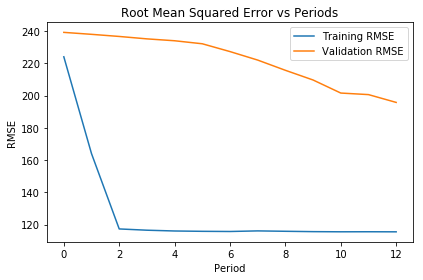

In [100]:

def normalize_linear_scale(examples_dataframe):
    processed_features = pd.DataFrame()
    processed_features['latitude'] = linear_scale(examples_dataframe['latitude'])
    processed_features['longitude'] = linear_scale(examples_dataframe['longitude'])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
    processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"],0,10000))
    processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
    processed_features["population"] = linear_scale(clip(examples_dataframe["population"],0,5000))
    processed_features["households"] = log_normalize(examples_dataframe["households"])
    processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
    processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"],0,5))
    return processed_features
    
normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_example = normalize_linear_scale(normalized_dataframe.head(12000))
normalized_validation_examples = normalize_linear_scale(normalized_dataframe.tail(5000))

_ = train_nn_regression_model(my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
                             steps=500,
                             batch_size=100,
                             hidden_units=[10,10],
                             training_examples = normalized_training_examples,
                             training_targets = training_targets,
                             validation_examples = normalized_validation_examples,
                             validation_targets = validation_targets)

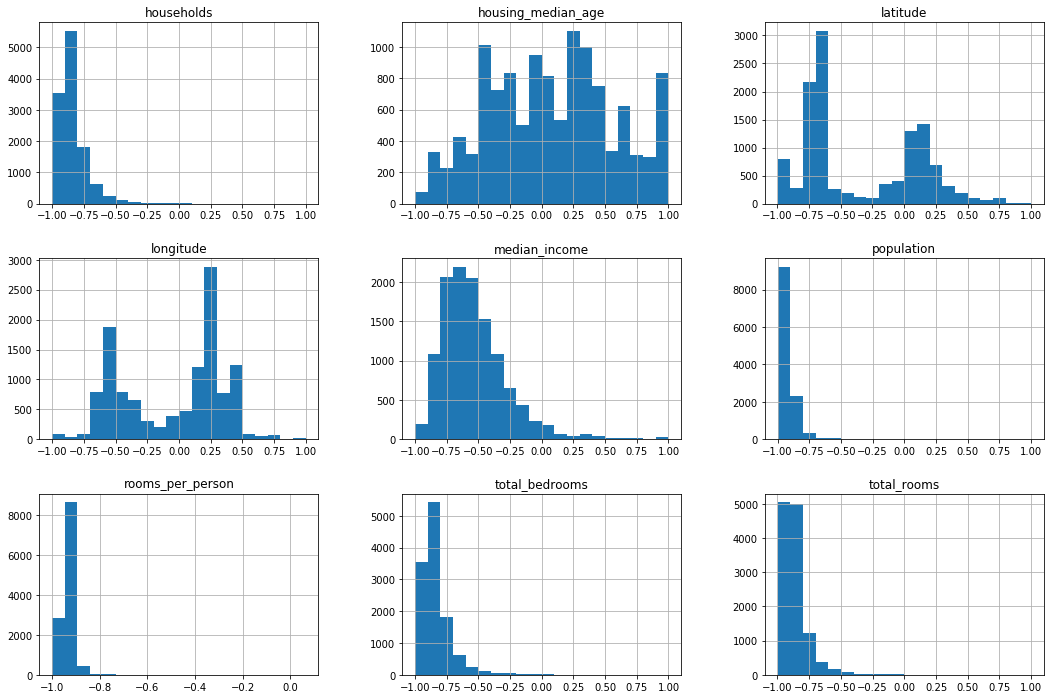

In [102]:
_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)


Training Model ...
RMSE(On the training data):
Period 00 : 232.74
Period 01 : 155.85
Period 02 : 108.38
Period 03 : 106.52
Period 04 : 104.92
Period 05 : 104.22
Period 06 : 102.96
Period 07 : 102.35
Period 08 : 102.18
Period 09 : 101.31
Period 10 : 100.84
Period 11 : 100.44
Period 12 : 100.09
Model training finished
Final RMSE for Training : 100.09
Final RMSE for Validation : 102.36


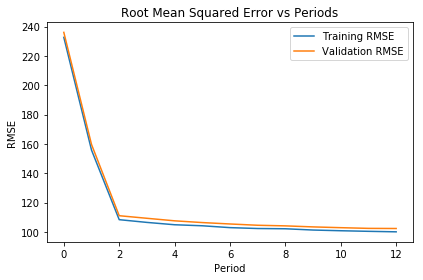

In [103]:
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)